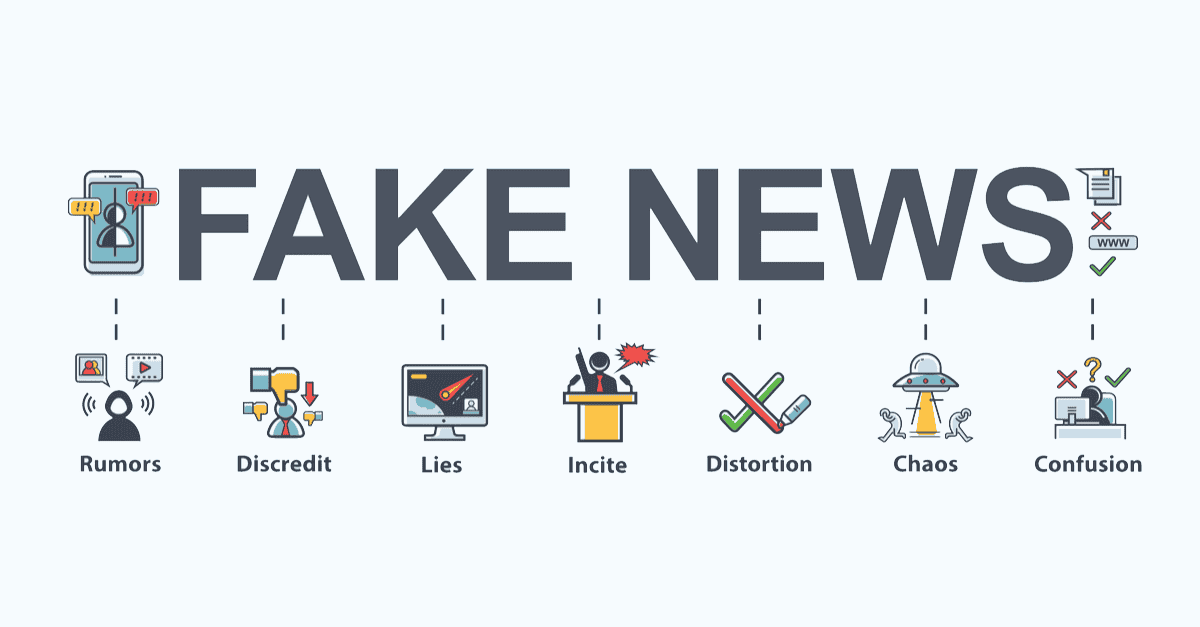

 <div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
        Introduction
</div>


 <div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
        Fake news or hoaxes refer to false or misleading information presented as news. The primary purpose of fake news is often to harm the reputation of a person or entity, or to generate revenue through advertising. Fake news may include false claims, factual distortions, or the dissemination of inaccurate information with a specific intent, often to manipulate public opinion or create confusion. This phenomenon can have serious implications for society, media, and democratic processes, making the detection and avoidance of fake news increasingly crucial in our ever-evolving information environment.
    </p>
</div>


Domain Knowledge :

1) Title -> Title of the News

2) Text -> Text or Content of the News

3) Label -> Labelling the news as Fake or Real

 <div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
       1. Import Libraries.
    </p>
</div>


In [ ]:
pip install twython 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from collections import Counter
import re
import string

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')


import warnings
warnings.filterwarnings('ignore')

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
       2. Load Data
    </p>
</div>


In [ ]:
df = pd.read_csv('/kaggle/input/fake-news/news.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.columns 

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
     3. Exploratioan Data
    </p>
</div>


In [ ]:
df1 = df.copy()

In [ ]:
df1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

df1['label'] = df1['label'].replace('REAL', '0')
df1['label'] = df1['label'].replace('FAKE', '1')
df1['label'] = df1['label'].astype('int32')

df1.drop(columns=['title'], inplace=True)


In [ ]:
stopword = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace('—', '') 
    text = [word for word in text.split(' ') if word not in stopword]
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)
    return text

df1["clean_text"] = df1["text"].apply(clean)


In [ ]:
df1.drop(columns=['text'], inplace=True)

In [ ]:
df1["word_count"] = df1['clean_text'].str.split().str.len()
df1

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df1['score'] = df1['clean_text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['sentiment'] = df1['score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['clean_text', 'score', 'sentiment']].head())

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
       Vizualization
    </p>
</div>


In [ ]:
colors = ['#99ff99', '#ffcc99']

label_counts = df1.groupby("label").size()
explode = [0.0] * len(label_counts)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=label_counts,  
    labels=label_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(label_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,  
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Label\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(label_counts.index, title="Label", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()


In [ ]:
colors = ['#ff9999', '#66b3ff', '#99ff99']

explode = (0.0, 0, 0)  

sentiment_counts =df1.groupby("sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

In [ ]:
sns.set(style="darkgrid", palette="muted", color_codes=True)

positive_reviews = df1[df1["sentiment"] == 'positive']  
negative_reviews = df1[df1["sentiment"] == 'negative'] 

sns.distplot(positive_reviews['word_count'], color='steelblue', label='Positive', kde=False, hist_kws={'alpha': 0.7})
sns.distplot(negative_reviews['word_count'], color='tomato', label='Negative', kde=False, hist_kws={'alpha': 0.7})

plt.title('Distribution of Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.show()

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
      All Words
    </p>
</div>


In [ ]:
df1['temp_list'] = df1['clean_text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Set2')

In [ ]:
all_words = ' '.join(df1['clean_text'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_words)
                   
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
Positive_sent = df1[df1['sentiment'] == 'positive']
Negative_sent = df1[df1['sentiment'] == 'negative']
Neutral_sent = df1[df1['sentiment'] == 'neutral']

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
      Positive Words
    </p>
</div>


In [ ]:
top = Counter([item for sublist in df1[df1['sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Set2')

In [ ]:
positive_words = [item for sublist in df1[df1['sentiment'] == 'positive']['temp_list'] for item in sublist]

word_counter = Counter(positive_words)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(['common', 'stopwords', 'you', 'may', 'want', 'to', 'add', 'custom', 'stop', 'words']), 
                min_font_size = 10).generate_from_frequencies(word_counter)
                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()


<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
      Neutral Words
    </p>
</div>


In [ ]:
top = Counter([item for sublist in df1[df1['sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Set2')

In [ ]:
neutral_words = [item for sublist in df1[df1['sentiment'] == 'neutral']['temp_list'] for item in sublist]

word_counter = Counter(neutral_words)

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=set(['common', 'stopwords', 'you', 'may', 'want', 'to', 'add', 'custom', 'stop', 'words']),
                      min_font_size=10).generate_from_frequencies(word_counter)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
      Negative Words
    </p>
</div>


In [ ]:
top = Counter([item for sublist in df1[df1['sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Set2')

In [ ]:
negative_words = [item for sublist in df1[df1['sentiment'] == 'negative']['temp_list'] for item in sublist]

word_counter = Counter(negative_words)

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=set(['common', 'stopwords', 'you', 'may', 'want', 'to', 'add', 'custom', 'stop', 'words']),
                      min_font_size=10, colormap='Reds').generate_from_frequencies(word_counter)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
      4. Data Prepocessing
    </p>
</div>


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
df2 = df1.copy()

In [ ]:
X = df2['clean_text'].values
y = df2['label'].values

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
       Split Data
    </p>
</div>


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
       5. Modeling 
    </p>
</div>


<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
       Passive Agressive Classifier
    </p>
</div>



In [ ]:
model_pa = make_imb_pipeline(TfidfVectorizer(), SMOTE(random_state=42), PassiveAggressiveClassifier())

In [ ]:
model_pa.fit(X_train, y_train)

In [ ]:
y_pred = model_pa.predict(X_test)

In [ ]:
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

In [ ]:
print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_rep_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<div style="background-color: #0074cc; padding: 10px; border-radius: 5px;">
    <p style="color: white; font-size: 14px; font-weight: bold;">
     6.Finish
    </p>
</div>



<div style="background-color: #ffffff; color: #000000; padding: 10px; border-radius: 5px;">
    <p style="font-size: 16px; font-weight: bold;">
       If you discovered this notebook to be useful or enjoyable, I'd greatly appreciate any upvotes.
    </p>
</div>


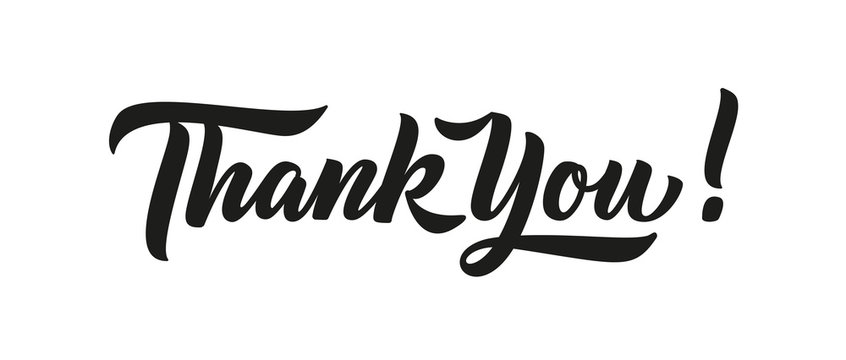